In [2]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

In [3]:
def plot_V_info(V_info):
    """[summary]

    Args:
        V_info ([type]): [description]
    """
    global fig, ax
    figscale, defaultSize = 2, np.array([8, 6])
    fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=figscale*defaultSize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4, left = 0.1, right = 0.7, bottom = 0.1, top = 0.9) 
    
    ax[0,0].hist(V_info["avg"])
    ax[0,0].set(xlabel="V_avg", ylabel="batches", title="Avg(Var)")
    
    ax[1,0].hist(V_info["std"])
    ax[1,0].set(xlabel="V_std", ylabel="batches", title="Std(Var)")

    ax[0,1].hist(V_info["max"])
    ax[0,1].set(xlabel="V_max", ylabel="batches", title="Max(Var)")

    ax[1,1].hist(V_info["min"])
    ax[1,1].set(xlabel="V_min", ylabel="batches", title="Min(Var)")

    plt.show()

def varAnalysis(X, verbose=False):
    V = np.var(X, axis=0)
    V_avg, V_std = np.mean(V), np.std(V)
    V_max, V_min = np.max(V), np.min(V)
    
    if verbose == True:
        print(f"V_avg: {np.mean(V):.3f}")    
        print(f"V_std: {np.std(V):.3f}")
        print(f"V_max: {np.max(V):.3f}")
        print(f"V_min: {np.min(V):.3f}")
    
    return V_avg, V_std, V_max, V_min

----------
csvBatch: 1


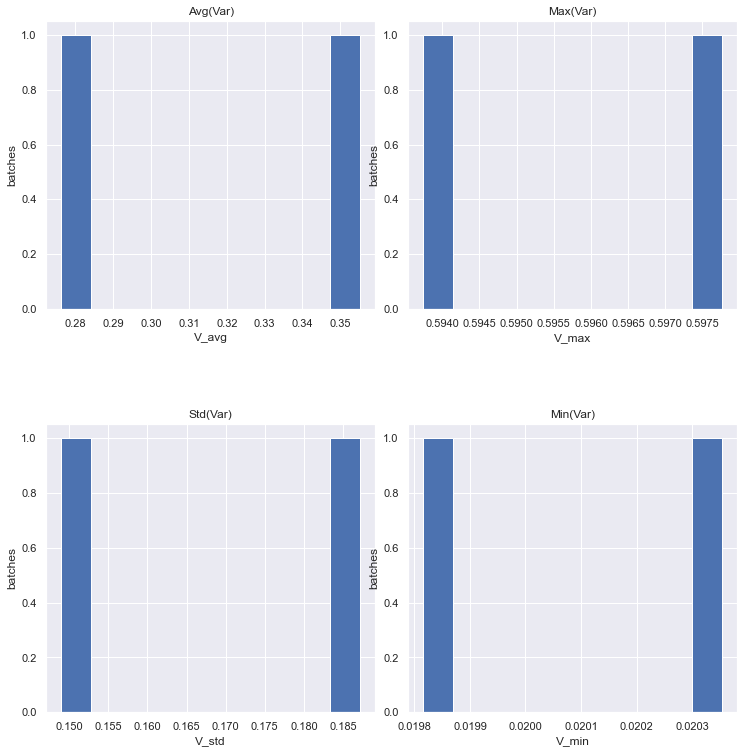

In [82]:
import time
from IPython.display import clear_output

start_time = time.time()

try:
    # There are about 220,000 features, so we can loop <= 110 times.
    csvBatchSize = 2000
    maxIteration = 1

    V_info = {}
    ps = []
    V_info["avg"] = np.empty(maxIteration + 1) 
    V_info["std"] = np.empty(maxIteration + 1) 
    V_info["max"] = np.empty(maxIteration + 1) 
    V_info["min"] = np.empty(maxIteration + 1) 

    for csvBatch_idx, csvBatch in enumerate(pd.read_csv("gtTypes_C.csv", chunksize=csvBatchSize)):
        data = csvBatch
        # current_time = time.time() - start_time
        # print(f"{current_time:.2f}")
        X = data.values[:, 1:].astype(float).T
        
        varAnalysisInfo = varAnalysis(X=X)
        V_info["avg"][csvBatch_idx], V_info["std"][csvBatch_idx] = varAnalysisInfo[:2]
        V_info["max"][csvBatch_idx], V_info["min"][csvBatch_idx] = varAnalysisInfo[2:]
        
        # Dynamically plot variance distributions
        V_info_sofar = {} 
        for key in V_info:
            V_info_sofar[key] = V_info[key][:csvBatch_idx + 1]
        clear_output(wait=True)
        print(f"----------\ncsvBatch: {csvBatch_idx}")
        plot_V_info(V_info_sofar)
        
        # Store p-values
        
        if csvBatch_idx == maxIteration:
            break
        
except KeyboardInterrupt:
    print("`stopped")

In [83]:
V_info 

{'avg': array([0.35528835, 0.27617677]),
 'std': array([0.18720417, 0.14895694]),
 'max': array([0.5977667 , 0.59374164]),
 'min': array([0.01981568, 0.02035444])}

In [84]:
varAnalysis(X=X)

(0.27617677360813053,
 0.14895694330654985,
 0.5937416361570463,
 0.020354437571013382)

----

## Process Targets

The mice were scored on a test and grouped into 3 categories: GT, IR, and ST. GT was the worst and ST was the best.

In [90]:
df = pd.read_csv("targets.csv")

# Check if targets.csv contains the same IDs as the feature matrix
targetRatIDs = df.loc[(df["Vendor"] == "Charles River")][["RatID", "Phenotype"]].values
miceIDs = np.array(data.columns)[1:].astype(int)
assert len((a:=set(targetRatIDs[:, 0])).intersection((b:=set(miceIDs)))) == 1780

# Remove uncommon elements
for number in a.difference(b):
    targetRatIDs[:, 0] = np.where((targetRatIDs[:, 0] == number), None, targetRatIDs[:, 0])    
targetRatIDs = pd.DataFrame(targetRatIDs, columns=["RatID", "Phenotype"]).dropna()
assert targetRatIDs.shape[0] == 1780

targetRatIDs = targetRatIDs.set_index("RatID").sort_index()
miceIDs.sort()
assert np.all(targetRatIDs.index.values == miceIDs.astype(int))

targetRatIDs = targetRatIDs.astype(str)
targetRatIDs["Phenotype"].value_counts()

for i, pt in enumerate(targetRatIDs.Phenotype.values):
    if 'GT' in pt:
        targetRatIDs.Phenotype.iloc[i] = '0'
    if 'IR' in pt:
        targetRatIDs.Phenotype.iloc[i] = '1'
    if 'ST' in pt:
        targetRatIDs.Phenotype.iloc[i] = '2'

assert len(targetRatIDs.Phenotype.value_counts()) == 3

Yr = targetRatIDs.Phenotype.values.astype(int).reshape(-1, 1)
Yr.shape, X.shape
# get_ps(X, Y)

((1780, 1), (1780, 2000))

----

## Get p values

In [135]:
from sklearn.linear_model import SGDClassifier
import torch
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

In [86]:
X.shape

(1780, 2000)

In [94]:
pd.DataFrame(Y).value_counts()

0    904
1    876
dtype: int64

In [95]:
pd.DataFrame(Yr).value_counts()

1    733
0    687
2    360
dtype: int64

In [148]:
# simulated target matrix, Y
rng = np.random.RandomState(7)
Y = rng.randint(0,2, X.shape[0]).reshape(-1,1)

print(X.T.shape)
def getCriterion(X, Y, get_coefs=False) -> np.ndarray:
    """ Feature selection criterion
    Args:
        X (np.ndarray, 2D): feature matrix
        Y (np.ndarray, 2D): target matrix
        get_coefs (bool, optional):  Defaults to False.
    Returns:
        
    """
    global ps, coefs
    items, coefs, ps = [], [], []
    try:
        # for each column of X
        for row in X.T:
            x = row.reshape(-1, 1)
            
            if get_coefs:
                # Calculate classification coefficients
                # model = SGDClassifier(loss='log') # logit model
                model = SGDClassifier(loss='hinge') # SVM classifier
                model.fit(x, Y)
                y_pred = model.predict(x)
                items.append(y_pred)
                coefs.append(model.coef_[0,0])

            else:
                # Calculate p-values from logit model
                # sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
                sm_model = sm.MNLogit(Y, sm.add_constant(x)).fit(disp=0)
                ps.append(sm_model.pvalues[1])
            
            
    except KeyboardInterrupt:
        ps = np.array(ps)
        print("stopped")
    
    if get_coefs:
        return (coefs:= np.array(coefs))
    else:
        return (ps:= np.array(ps))
        
getCriterion(X, Y, get_coefs=True)

(2000, 1780)


array([-1.55919560e-14, -5.51480726e-01,  3.61973479e-01, ...,
        3.85817354e-01,  1.09292604e+00, -3.19907867e-01])

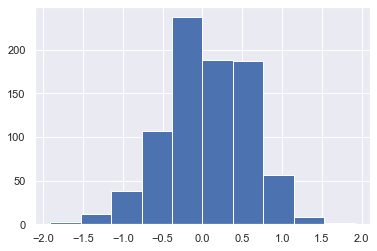

In [140]:
plt.hist(coefs);

In [147]:
torch.topk(torch.Tensor(coefs), k=100)

torch.return_types.topk(
values=tensor([1.9126, 1.5995, 1.3569, 1.2078, 1.2078, 1.2078, 1.2078, 1.1922, 1.1802,
        1.1488, 1.1437, 1.1347, 1.1080, 1.0831, 1.0831, 1.0831, 1.0831, 1.0680,
        1.0576, 1.0422, 1.0297, 1.0198, 1.0198, 1.0192, 1.0044, 1.0044, 0.9960,
        0.9940, 0.9835, 0.9597, 0.9538, 0.9479, 0.9450, 0.9220, 0.9191, 0.9149,
        0.9149, 0.9100, 0.8900, 0.8900, 0.8825, 0.8825, 0.8791, 0.8741, 0.8741,
        0.8631, 0.8627, 0.8627, 0.8616, 0.8520, 0.8520, 0.8460, 0.8197, 0.8197,
        0.8197, 0.8153, 0.8128, 0.8089, 0.8082, 0.7920, 0.7920, 0.7899, 0.7817,
        0.7738, 0.7716, 0.7683, 0.7627, 0.7627, 0.7602, 0.7602, 0.7602, 0.7564,
        0.7564, 0.7564, 0.7564, 0.7478, 0.7478, 0.7470, 0.7353, 0.7353, 0.7353,
        0.7220, 0.7220, 0.7220, 0.7220, 0.7184, 0.7153, 0.7153, 0.7153, 0.7120,
        0.7120, 0.7120, 0.7120, 0.7100, 0.7087, 0.7087, 0.7087, 0.6953, 0.6925,
        0.6925]),
indices=tensor([480, 444, 443,   2, 221, 732, 402, 431, 146, 515, 201,

In [146]:
from sklearn.feature_selection import SelectKBest, chi2

X_dummy = SelectKBest(chi2, k=200).fit_transform(X, Y)
X_dummy.shape

(1780, 200)

- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

0.09355327625915083

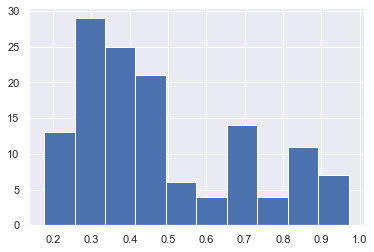

In [256]:
ps = np.abs(ps)
plt.hist(ps);
np.percentile(np.abs(coefs), 25)

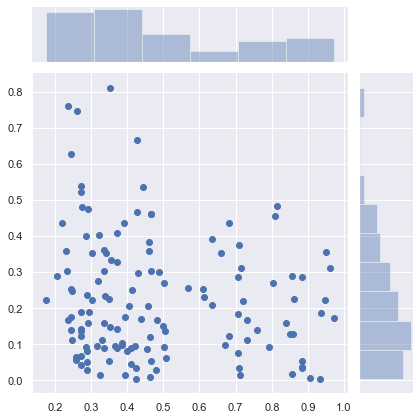

In [258]:
import seaborn as sns; sns.set()

sns.jointplot(ps, coefs, kind="scatter")

0.09355327625915083

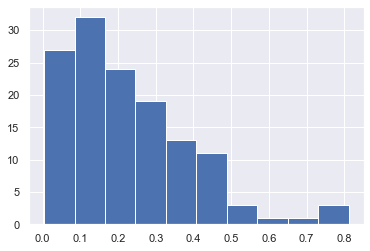

In [257]:
coefs = np.abs(coefs)
plt.hist(coefs);
np.percentile(np.abs(coefs), 25)